In [1]:
using LinearAlgebra, Statistics, Distributions, Test, Plots, FFTW
pyplot()
import Base: +, *, copy

using BenchmarkTools, ProfileView

In [2]:
function +(spinorA::Tuple{Vector{Vector{Int64}}, Vector{ComplexF64}}, spinorB::Tuple{Vector{Vector{Int64}}, Vector{ComplexF64}})
    for i in 1:length(spinorA[2])
        spinorA[2][i] += spinorB[2][i]
    end
    return spinorA        
end
function initialize(spins, coeffs)
    L = length(spins[1])
    zeroSpinor = ( [(reverse(digits(i, base=2, pad=L))) for i in 0:2^L-1], zeros(ComplexF64, 2^L) )
    for i in 1:length(spins)
        for j in 1:length(zeroSpinor[1])
            if spins[i] == zeroSpinor[1][j]
                zeroSpinor[2][j] += coeffs[i]
            end
        end
    end
    return zeroSpinor
end
function bubblesort(spinor) # Not great, but no heap allocations!
    for i in 1:length(spinor[1])
        for j in i:length(spinor[1])
            if spinor[1][i] > spinor[1][j]
                spinor[1][i], spinor[1][j] = spinor[1][j], spinor[1][i]
                spinor[2][i], spinor[2][j] = spinor[2][j], spinor[2][i]
            end
        end
    end
    return spinor
end
function *(spinorA::Tuple{Vector{Vector{Int64}}, Vector{ComplexF64}}, spinorB::Tuple{Vector{Vector{Int64}}, Vector{ComplexF64}})
    result = 0.0
    for i in 1:length(spinorA[2])
        result += conj(spinorA[2][i])*spinorB[2][i]
    end
    return round(result,digits=10)
end
function normalize!(spinor::Tuple{Vector{Vector{Int64}}, Vector{ComplexF64}})
    mag = sqrt(spinor*spinor)
    for i in 1:length(spinor.coefficients)
        spinor.coefficients[i] = spinor.coefficients[i]/mag
    end #spinor on left is already daggered. See *(::Spinor,::Spinor)
end

function *(α::Any, spinorB::Tuple{Vector{Vector{Int64}}, Vector{ComplexF64}}) 
    for i in 1:length(spinorB[2])
        spinorB[2][i] *= α
    end
    return spinorB
end
*(spinorB::Tuple{Vector{Vector{Int64}}, Vector{ComplexF64}}, α::Any) = α*spinorB

* (generic function with 547 methods)

In [3]:
#=function σx(n::Int,spinor::Spinor)
    newspinor = deepcopy(spinor)
    for state in newspinor.spins
        state[n] = (state[n] + 1) % 2
    end
    return newspinor
end=#
function mycopy(s1, s2)
    for i in 1:length(s1[1])
        for j in 1:length(s1[1][1])
            s1[1][i][j] = s2[1][i][j]
        end
    end
    for i in 1:length(s1[2])
        s1[2][i] = s2[2][i]
    end
    return nothing
end
function σx(n::Int, spinor::Tuple{Vector{Vector{Int64}}, Vector{ComplexF64}}, newspinor::Tuple{Vector{Vector{Int64}}, Vector{ComplexF64}})
    
    mycopy(newspinor, spinor)
    for i in 1:length(spinor[1])
        newspinor[1][i][n] = (spinor[1][i][n] + 1) % 2
    end

    return bubblesort(newspinor)
end
function σx!(n::Int, spinor::Tuple{Vector{Vector{Int64}}, Vector{ComplexF64}})
    for i in 1:length(spinor[1])
        spinor[1][i][n] = (spinor[1][i][n] + 1) % 2
    end
    return bubblesort(spinor)
end

#=function σy(n::Int,spinor::Spinor)
    newspinor = deepcopy(spinor)
    for (i,state) in enumerate(newspinor.spins)
        state[n] = (state[n] + 1) % 2
        newspinor.coefficients[i] *= spinor.spins[i][n] == 1 ? im : -im
    end
    return newspinor
end=#
function σy(n::Int, spinor::Tuple{Vector{Vector{Int64}}, Vector{ComplexF64}}, newspinor::Tuple{Vector{Vector{Int64}}, Vector{ComplexF64}})
    mycopy(newspinor, spinor)
    for i in 1:length(spinor[1])
        newspinor[2][i] *= spinor[1][i][n] == 1 ? im : -im
        newspinor[1][i][n] = (spinor[1][i][n] + 1) % 2
    end
    return bubblesort(newspinor)
end
function σy!(n::Int, spinor::Tuple{Vector{Vector{Int64}}, Vector{ComplexF64}})
    for i in 1:length(spinor[1])
        spinor[2][i] *= spinor[1][i][n] == 1 ? im : -im
        spinor[1][i][n] = (spinor[1][i][n] + 1) % 2
    end
    return bubblesort(spinor)
end
#=function σz(n::Int,spinor::Spinor)
    newspinor = deepcopy(spinor)
    for i in 1:length(newspinor.coefficients)
        newspinor.coefficients[i] *= ((spinor.spins[i][n] == 1) ? 1 : -1)
    end
    return newspinor
end=#
function σz(n::Int,spinor::Tuple{Vector{Vector{Int64}}, Vector{ComplexF64}}, newspinor::Tuple{Vector{Vector{Int64}}, Vector{ComplexF64}})
    #mycopy(newspinor, spinor) # I don't think I need this copy!
    for i in 1:length(spinor[1])
        newspinor[2][i] = spinor[2][i] *  ((spinor[1][i][n] == 1) ? 1 : -1)
    end
    #return bubblesort(newspinor)
    return newspinor
end
function σz!(n::Int, spinor::Tuple{Vector{Vector{Int64}}, Vector{ComplexF64}})
    for i in 1:length(spinor[2])
        spinor[2][i] *= ((spinor[1][i][n] == 1) ? 1 : -1)
    end
    #return bubblesort(spinor)
    return spinor
end
#=σiσj(i,j,spinor::Spinor) = σx(i,σx(j, spinor)) + σy(i,σy(j, spinor)) + σz(i,σz(j, spinor))
σiσj(i,j,spinor::Spinor, theta) = theta*σx(i,σx(j, spinor)) + theta*σy(i,σy(j, spinor)) + σz(i,σz(j, spinor))=#
function efficσiσj(i,j, spinor1, spinor2, spinor3, theta) # spinor2 and 3 just need to be the same size
    mycopy(spinor2,spinor1)
    if theta != 0.0
        σx!(i,σx!(j,spinor2))
        mycopy(spinor3,theta*spinor2)
        mycopy(spinor2,spinor1)
        σy!(i, σy!(j, spinor2))
        spinor3 += theta*spinor2
        mycopy(spinor2,spinor1)
        σz!(i,σz!(j, spinor2))
        spinor3 += spinor2
    else
        σz!(i,σz!(j, spinor2))
        mycopy(spinor3,spinor2)
    end
    return spinor3
    #return theta*σx!(i,σx!(j, spinor)) + theta*σy!(i,σy!(j, spinor)) + σz!(i,σz!(j, spinor))
end


efficσiσj (generic function with 1 method)

In [4]:
function lalala()
    s1 = initialize([[0,1],[1,0]], [1/sqrt(2) + 0.0im,1/sqrt(2)+0.0im])
    s2 = deepcopy(s1)
    s3 = deepcopy(s1)
    i,j = 1,2
    t = 1.0
    #@time efficσiσj(i,j, s1, s2, s3, t)
    @time σz(i, s1, s2)
    return s1
    #@time σz!(2, s1) #ARRRGH!!! now sz is allocating but sx and sy aren't??
end
lalala()

  0.000080 seconds


([[0, 0], [0, 1], [1, 0], [1, 1]], ComplexF64[0.0 + 0.0im, 0.7071067811865475 + 0.0im, 0.7071067811865475 + 0.0im, 0.0 + 0.0im])

In [5]:
#change getJtensor
getBasis(L) = [ initialize([(reverse(digits(i, base=2, pad=L)))],[1]) for i in 0:2^L-1]

function operatorToMatrix(operator, basis)
    mat = zeros(length(basis),length(basis))
    for (i,spinorI) in enumerate(basis)
        for (j,spinorJ) in enumerate(basis)
                    mat[i, j] = (spinorI*operator(spinorJ))
        end
    end
    return mat
end
function operatorToMatrix!(mat, operator, basis)
    for (i,spinorI) in enumerate(basis)
        for (j,spinorJ) in enumerate(basis)
            mat[i, j] = (spinorI*operator(spinorJ))
        end
    end
end
function getJtensor(L,β, theta; betaArray=[])
    betas = betaArray == [] ? [β^i for i in 0:L-2] : betaArray
    length(betas) != L-1 ? error("betaArray is wrong length.") : nothing

    jTensor = zeros(2^L, 2^L, Int(L*(L-1)/2))
    basis = getBasis(L)
    s2 = deepcopy(basis[1])
    s3 = deepcopy(basis[1])
    baseIndex = 0
    @views for k in 1:L-1
        for n in 1:L-k
            if betas[k] != 0.0
                operatorToMatrix!(jTensor[:,:,baseIndex + n], x->betas[k]*efficσiσj(n,n+k,x,s2,s3,theta), basis)
            end
        end
        baseIndex += L-k
    end
    return jTensor
end
function getHtensor(L)
    hTensor = zeros(2^L, 2^L, L)
    basis = getBasis(L)
    s2 = deepcopy(basis[1])
    @views for n in 1:L
            operatorToMatrix!(hTensor[:,:,n], x->σz(n,x,s2), basis)
    end
    return hTensor
end
function levelspacing(vals)
    sort!(vals)
    for i in 1:length(vals)-1
        vals[i] = vals[i+1] - vals[i]
    end
    for i in 1:length(vals)-2
        vals[i] = min(vals[i],vals[i+1])/max(vals[i],vals[i+1])
    end
    return mean(@view vals[1:end-2])
end

levelspacing (generic function with 1 method)

In [6]:
function getlevelspacingrat(L, J0, σj, σh, theta)
    niters = 100
    spac = zeros(niters)
    for iteration in 1:niters
        Hh = getDTCHam2(L, J0, σj, σh, theta)
        spac[iteration] = levelspacing(eigvals(Hh))
        #println(eigvals(Hh))
    end
    return mean(spac)
end


function getDTCHam2(L::Integer, J0::Real, σj::Real, σh::Real, theta::Real; β=0.0)
    hs = zeros(L)
    if σh > 0.0
        for i in eachindex(hs)
            hs[i] = rand(Uniform(0.0, σh))
            #hs[i] = rand(Normal(0, σh))
        end
    else
        hs[:] .= 0.0
    end

    js = zeros(Int(L*(L-1)/2))
    if σj > 0.0
        for i in eachindex(js)
            #js[i] = rand(truncated(Normal(J0, σj),0.0, Inf))
            js[i] = rand(Uniform(J0-σj, J0+σj))
        end
    else
        js[:] .= J0
    end

    jTensor = getJtensor(L, β, theta)
    hTensor = getHtensor(L);
    
    Hj = zeros(2^L,2^L)
    Hh = zeros(2^L,2^L)
    
    for j in 1:Int(L*(L-1)/2), m in 1:2^L, n in 1:2^L
        Hj[m,n] = Hj[m,n] + (js[j] * jTensor[m,n,j])
    end
    
    for j in 1:L, m in 1:2^L, n in 1:2^L
        Hh[m,n] = Hh[m,n] + hs[j] * hTensor[m,n,j]
    end
    Hh .= Hh .+ Hj
    
    return Hh
end

function efficientHam(Hspace, hs, js, jTensor, hTensor)
  
    L = Int(log2(size(Hspace)[1]))
    for i in 1:2^L, j in 1:2^L
        Hspace[i,j] = 0.0 + 0.0im
    end
    for j in 1:Int(L*(L-1)/2), m in 1:2^L, n in 1:2^L
        Hspace[m,n] += (js[j] * jTensor[m,n,j])
    end
    
    for j in 1:L, m in 1:2^L, n in 1:2^L
        Hspace[m,n] += hs[j] * hTensor[m,n,j]
    end
    
    return Hspace
end
function getKet(spinArray)
    L = length(spinArray)
    spinBasis=[reverse(digits(i, base=2, pad=length(spinArray))) for i in 0:2^length(spinArray)-1]
    coeffs = zeros(2^L)
    for i in eachindex(spinBasis)
        coeffs[i] = spinBasis[i] == spinArray ? 1.0 : 0.0
    end
    return coeffs
end
function getSpins!(ket, spinBasis, coeffs) # Clean this up
    L = Int(log2(length(ket)))

    #abs2ket = abs2.(ket)
    coeffs .= 0.0
    
    for i in eachindex(spinBasis)
        if ket[i] != 0.0
            for j in 1:L
                coeffs[j] += abs2(ket[i])*(spinBasis[i][j] == 0 ? -1.0 : 1.0)
            end
        end
    end
    return coeffs
end

function U1(L,ε) 
    basis = getBasis(L)
    s2 = deepcopy(basis[1])
    return exp(-im .* operatorToMatrix(x->π/2*(1 - ε)*sum([σx(i,x,s2) for i in 1:L]), basis) )
end
function efficU1(mat, L, ε) 
    basis = getBasis(L)
    s2 = deepcopy(basis[1])
    operatorToMatrix!(mat, x->π/2*(1 - ε)*sum([σx(i,x,s2) for i in 1:L]), getBasis(L))
    return mat #exp(-im .* mat )
end

efficU2(Hspace, hs, js, jTensor, hTensor) = exp(-im.*efficientHam(Hspace, hs, js, jTensor, hTensor))

U2(L, J0, sigJ, sigH; thet=1.0) = exp(-im.*getDTCHam2(L, J0, sigJ, sigH, thet))

function U_levelspacing(L, ε, J0, sigJ, sigH, theta)       
    niters=100
    spac = zeros(niters)
    for i in 1:niters
        spac[i] = levelspacing(mod.(real.(round.(-im.*log.(eigvals(U1(L,ε)*U2(L, J0, sigJ, sigH; thet=theta))),digits=10)),2*pi))
    end
    return mean(spac)
end
#= FIXME getDTCHam2 (efficient) =#

U_levelspacing (generic function with 1 method)

In [17]:
#function averageSpin(newKet, oldKet, spinBasis)
    
#end
function autocorrelator(spins, Ureal1, Ureal2, N)
    initKet = getKet(spins)
    L = length(spins)
    negOneSpins = replace(spins, 0 => -1)
    basis = [reverse(digits(i, base=2, pad=L)) for i in 0:2^L-1]

    autoCor = zeros(N+1)
    moreSpins = zeros(L,N+1)
    currentKet = deepcopy(initKet)
    newKet = zeros(2^L)

    autoCor[1] = 1.0
    moreSpins[:,1] = negOneSpins

    for i in 2:N+1
        newKet = Ureal2*Ureal1*currentKet
        getSpins!(newKet, basis, view(moreSpins,:,i))
        #autoCor[i] = mean(moreSpins[:,i].*negOneSpins)
        autoCor[i] = (moreSpins[:,i].*negOneSpins)[Int(round(L/2))]
        currentKet = newKet
    end
    #println(autoCor)
    return autoCor, moreSpins
end
function averageAutocorrelator(niters, nperiods, spins, ε, J0, σj, σh, t)
    
    L = length(spins)
    cors = zeros(nperiods+1, niters)
    finalCors=zeros(nperiods+1)
    allSpins = zeros(L, nperiods+1, niters)
    

    
    Hj = zeros(2^L,2^L)
    Hh = zeros(2^L,2^L)

    for i in 1:niters
        cors[:,i],allSpins[:,:, i]  = autocorrelator(spins, U1(L, ε), U2(L, J0, σj , σh, thet=t), nperiods)
    end
    finalCors = mean(cors, dims=2)
    allSpins[:,:,1] = mean(allSpins,dims=3)
    return finalCors, allSpins[:,:,1]
end
function gethsandjs(niters, L, J0, σj, σh)
    hs = zeros(niters, L)
    js = zeros(niters, Int(L*(L-1)/2))
    for i in eachindex(hs)
        if σh > 0.0
            hs[i] = rand(Uniform(0.0, σh))
        else
            hs[i] = 0.0
        end
    end

    for i in eachindex(js)
        if σj > 0.0
            js[i] = rand(Uniform(J0-σj, J0+σj))
        else
            js[i] = 0.0
        end
    end
    return hs, js
end
function effAvgAutoCor(niters, nperiods, spins, ε, J0, σj, σh, t)
    
    L = length(spins)
    u1 = newU1(L, ε)
    Hspace = zeros(2^L, 2^L)

    hs, js = gethsandjs(niters, L, J0, σj, σh)

    
    cors = zeros(nperiods+1, niters)
    finalCors=zeros(nperiods+1)
    allSpins = zeros(L, nperiods+1, niters)
    jTensor = getJtensor(L, 0.0, t) #β=0.0
    hTensor = getHtensor(L)

    for i in 1:niters
        cors[:,i],allSpins[:,:, i]  = autocorrelator(spins, u1, efficU2(Hspace,  hs[i,:] ,  js[i,:], jTensor, hTensor), nperiods)
        if i % 10 == 0
            println("Finished ",i,"th iteration")
        end
    end
    finalCors = mean(cors, dims=2)
    allSpins[:,:,1] = mean(allSpins,dims=3)
    return finalCors, allSpins[:,:,1]
end

effAvgAutoCor (generic function with 1 method)

In [18]:
function newU1(L, ε)
    mat = zeros(2^L,2^L)
    basis = getBasis(L)
    answers = deepcopy(basis)    
    for i in 1:2^L
        for k in 1:L
            σx(k,basis[i],answers[k])
        end
        for k in 2:L 
            answers[1] += answers[k] # This is where the allocations happen
        end 
        for j in 1:2^L
            mat[j,i] = basis[j]*answers[1]
        end
    end
    return round.(exp(-im * mat .* (1-ε) * pi/2 ), digits=15)
end

newU1 (generic function with 1 method)

## Spin echo - J0 = ε = 0

Finished 10th iteration
Finished 20th iteration
Finished 30th iteration
Finished 40th iteration
Finished 50th iteration
Finished 60th iteration
Finished 70th iteration
Finished 80th iteration
Finished 90th iteration
Finished 100th iteration


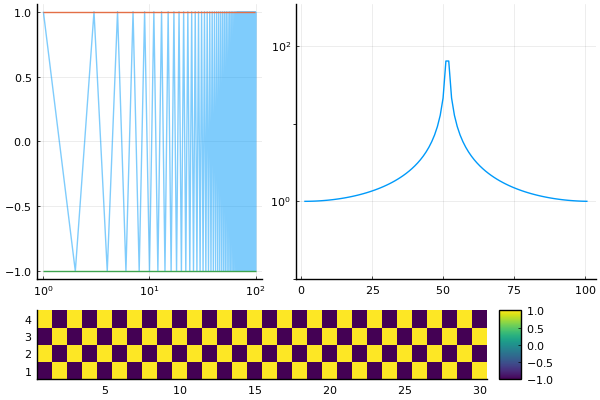

In [19]:
pyplot()
n = 100
realres, spinmap = effAvgAutoCor(100, n, [0,1,0,1], 0.0, 0.0, 0.0, 0.0, 1.0)
res = abs.(fft(realres))
l = @layout [a b ; c{0.2h}] 
plot(realres, opacity=0.5,xscale=:log10, legend=false)
plot!(collect(1:2:n),realres[1:2:n])
p1 = plot!([1; collect(2:2:n)],[-1.0 ; realres[2:2:n]])
p21 = plot(res, yscale =:log10, ylims=(0.1,350), legend=false)
p3 = heatmap(spinmap[:,1:30], c=:viridis, clims=(-1,1))
plot(p1,p21, p3, layout=l)

## Turn on interactions. No onsite disorder

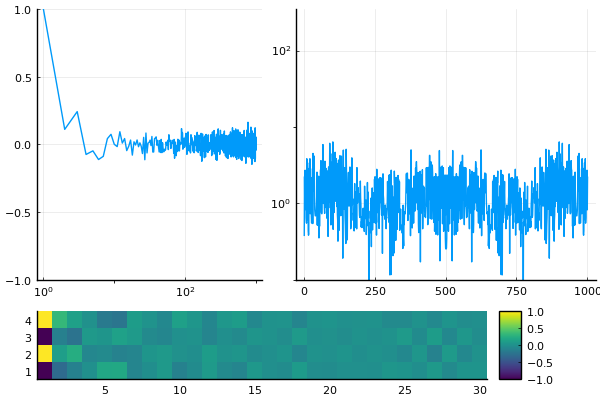

In [133]:
n = 1000
realres, spinmap = averageAutocorrelator(100, n, [0,1,0,1], 0.0, 1.0, 0.2, 0.0, 1.0)
res = abs.(fft(realres))
l = @layout [a b ; c{0.2h}] 
p1=plot(realres,xscale=:log10, ylims=(-1,1),legend=false)
#plot!(collect(1:2:n),realres[1:2:n])
#p1 = plot!([1; collect(2:2:n)],[-1.0 ; realres[2:2:n]])
p21 = plot(res, yscale =:log10, ylims=(0.1,350), legend=false)
p3 = heatmap(spinmap[:,1:30], c=:viridis, clims=(-1,1))
plot(p1,p21, p3, layout=l)

## MBL with onsite and Ising-even disorder

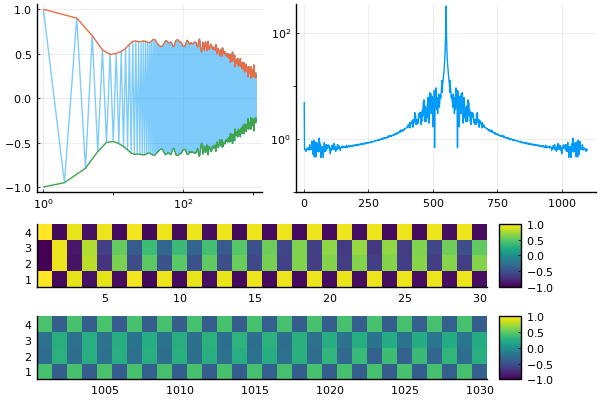

In [13]:
n = 1100
init=[1,0,0,1] #rand([0,1],6)
jz = 1.0
ε = 0.1
σh = 10.0
realres, spinmap = effAvgAutoCor(100, n, init, ε, jz, 0.2*jz, σh, 0.0)
res = abs.(fft(realres))
l = @layout [a b ; c{0.2h}; d{0.2h}] 
plot(realres, opacity=0.5, xscale=:log10, legend=false)
plot!(collect(1:2:n),realres[1:2:n])
p1 = plot!([1; collect(2:2:n)],[-1.0 ; realres[2:2:n]])
p21 = plot(res, yscale =:log10, ylims=(0.1,350), legend=false)
p3 = heatmap(spinmap[:,1:30], c=:viridis, clims=(-1,1))
howitsgoing = 1001:1030
p4 = heatmap(collect(howitsgoing), collect(1:length(init)), spinmap[:,howitsgoing], c=:viridis, clims=(-1,1))#print(spinmap[:,1001:1030])
plot(p1,p21, p3, p4, layout=l)

# Check for MBL using level spacing ratios

In [75]:
n = 10
σh = 1.0
eps = range(0,1, length=n)
rats = zeros(n)
for i in 1:length(eps)
    rats[i] = U_levelspacing(5, eps[i], jz, jz*0.2, σh, 0.0)
end
#plot(eps,rats)b

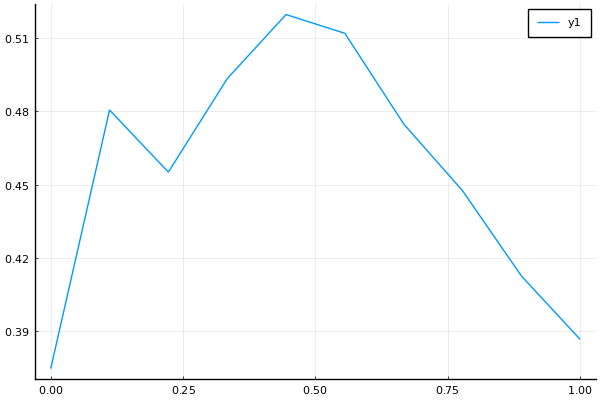

In [76]:
plot(eps, rats)

## MBL PM

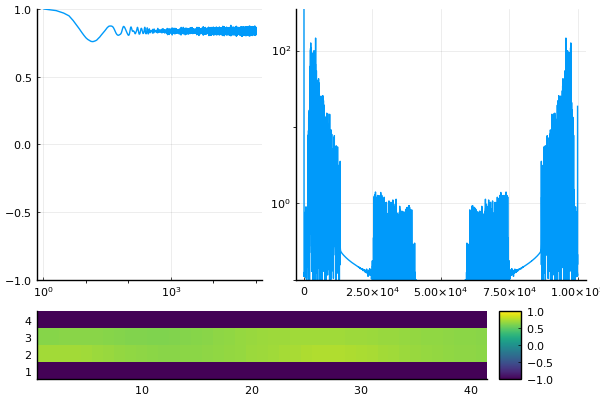

In [33]:
n = 100000
init = [0,1,1,0]
jz = 1.0
ε = 0.95
σh = 0.05
realres, spinmap = averageAutocorrelator(100, n, init, ε, jz, 0.2*jz, σh, 0.0)
res = abs.(fft(realres))
l = @layout [a b ; c{0.2h}] 
p1 = plot(realres, opacity=1.0,xscale=:log10, ylims=(-1,1),legend=false)
#plot!(collect(1:2:n),realres[1:2:n])
#p1 = plot!([1; collect(2:2:n)],[-1.0 ; realres[2:2:n]])
p21 = plot(res, yscale =:log10, ylims=(0.1,350), legend=false)
howitsgoing = 10000:10040
p3 = heatmap(collect(howitsgoing), collect(1:length(init)), spinmap[:,howitsgoing], c=:viridis, clims=(-1,1))
plot(p1,p21, p3, layout=l)

In [22]:
ProfileView.@profview effAvgAutoCor(100, n, [1,0,0,1,0,1,0,1], ε, jz, 0.2*jz, σh, 0.0)


Finished 10th iteration
Finished 20th iteration
Finished 30th iteration
Finished 40th iteration
Finished 50th iteration
Finished 60th iteration
Finished 70th iteration
Finished 80th iteration
Finished 90th iteration
Finished 100th iteration


Gtk.GtkWindowLeaf(name="", parent, width-request=-1, height-request=-1, visible=TRUE, sensitive=TRUE, app-paintable=FALSE, can-focus=FALSE, has-focus=FALSE, is-focus=FALSE, focus-on-click=TRUE, can-default=FALSE, has-default=FALSE, receives-default=FALSE, composite-child=FALSE, style, events=0, no-show-all=FALSE, has-tooltip=FALSE, tooltip-markup=NULL, tooltip-text=NULL, window, opacity=1.000000, double-buffered, halign=GTK_ALIGN_FILL, valign=GTK_ALIGN_FILL, margin-left, margin-right, margin-start=0, margin-end=0, margin-top=0, margin-bottom=0, margin=0, hexpand=FALSE, vexpand=FALSE, hexpand-set=FALSE, vexpand-set=FALSE, expand=FALSE, scale-factor=2, border-width=0, resize-mode, child, type=GTK_WINDOW_TOPLEVEL, title="Profile", role=NULL, resizable=TRUE, modal=FALSE, window-position=GTK_WIN_POS_NONE, default-width=800, default-height=600, destroy-with-parent=FALSE, hide-titlebar-when-maximized=FALSE, icon, icon-name=NULL, screen, type-hint=GDK_WINDOW_TYPE_HINT_NORMAL, skip-taskbar-hint